In [1]:
%matplotlib inline
import time
import pandas as pd
from scipy.stats import skew, kurtosis, mode, describe, moment
import numpy as np
import matplotlib.pyplot as plt
import os
#import scienceplots
from tqdm import tqdm
from scipy.integrate import cumulative_trapezoid

#plt.style.use('science')

# Loading Sirocco Profiles
all_results = np.load('sirocco_data.npy', allow_pickle=True).item()


H_alpha = 6562.819 # Å

def angstrom_to_kms(wavelength):
    """Converts wavelength in angstroms from central h_alpha line to velocity in km/s.
    Args:
        wavelength (float): wavelength in angstroms"""
    kms = (wavelength - H_alpha) * 299792.458 / H_alpha
    return kms

# =============================================================================
run_num = 415 # TODO CHANGE RUN NUMBER HERE !!!!
# =============================================================================

# Load velocity data
wavelength_data = all_results[run_num]['wavelengths']
velocity_data = angstrom_to_kms(wavelength_data)

#Load flux data
flux_data = all_results[run_num]['flux']
continuum_data = all_results[run_num]['continuum']

# Convert data to radial velocities and continuum normalised flux
flux_norm = flux_data / continuum_data

indexes = np.where((velocity_data > -4000) & (velocity_data < 4000))
flux_norm = flux_norm[indexes]
velocity_data = velocity_data[indexes]
    


We are working out the zeroth moment. This is the integrated line flux. 

$m_0 = \int_{v_1}^{v_2}(\frac{f_{line}}{f_{continuum}}-1)dv$


In [2]:
def zero_moment(flux, velocities):
    """Calculating the zeroth moment of the line.
    Args:
        flux (array): continuum-nomalised flux values, ie f_line/f_continuum
        velocity (array): Radial velocities from -4000 to 4000 km/s around Halpha"""
        
    zero_moment = np.trapz(flux-1, velocities)
    return zero_moment

print(f'm_0 = {zero_moment(flux_norm, velocity_data)}')

m_0 = 62.15294414875352


- We are working out the raw first moment. This should be the mean radial velocity of the emission line. 
    - So when I plot the mean vertical line. The look somewhere sensible around 0km/s, ie not the positioned on wings.
    - As our dataset isn't a pdf, we normalise by the summed data, ie m_0
  
$m_1 = \mu_1 = \frac{\mathbb{E}[X]}{m_0} = \frac{\int_{v_1}^{v_2} v(\frac{f_{line}}{f_{continuum}}-1)dv}{\int_{v_1}^{v_2}(\frac{f_{line}}{f_{continuum}}-1)dv} = \frac{\sum_{i}v_i*(\frac{f_{line,i}}{f_{continuum,i}}-1)}{\sum_{i}(\frac{f_{line,i}}{f_{continuum,i}}-1)} = \frac{\int_{v_1}^{v_2} v(\frac{f_{line}}{f_{continuum}}-1)dv}{m_0} $ 

In [3]:
def mean_raw_moment(flux, velocities):
    """Calculating the first raw moment of the emission line profile.

    Args:
        flux (array): continuum-nomalised flux values, ie f_line/f_continuum
        velocities (array): Radial velocities from -4000 to 4000 km/s around Halpha
    """
    #mu_1_sum = np.sum(velocities * (flux - 1)) / np.sum(flux - 1)
    if np.sum(flux - 1.0 < 0) > 50:
        print('Warning: This is going to break bad')
    mu_1 = np.trapz(velocities * (flux - 1.0), velocities) / zero_moment(flux, velocities)
    return mu_1

print(f'm_1 (mean) = {mean_raw_moment(flux_norm, velocity_data)} km/s')


m_1 (mean) = -305.94315213871556 km/s


We are working on the second centralised moment. This is the variance approximating the width of the emission line.

$m_2 = \sigma^2 = \frac{\int_{v_1}^{v_2}(v-\mu_1)^2(\frac{f_{line}}{f_{continuum}}-1)dv}{\int_{v_1}^{v_2}(\frac{f_{line}}{f_{continuum}}-1)dv} = \frac{\int_{v_1}^{v_2}(v-\mu_1)^2(\frac{f_{line}}{f_{continuum}}-1)dv}{m_0}$

$\sigma = \sqrt{m_2}$


In [4]:
def variance_central_moment(flux, velocities):
    """Calculating the second central moment of the emission line profile.

    Args:
        flux (array): continuum-nomalised flux values, ie f_line/f_continuum
        velocities (array): Radial velocities from -4000 to 4000 km/s around Halpha
    """
    mu_1 = mean_raw_moment(flux, velocities)
    variance = np.trapz((velocities - mu_1)**2 * (flux - 1), velocities) / zero_moment(flux, velocities)
    return variance

var = variance_central_moment(flux_norm, velocity_data)
std = np.sqrt(var)
print(f'var = {var} (km/s)^2')
print(f'std = {std} km/s')

var = 1355212.4940561745 (km/s)^2
std = 1164.1359431166854 km/s


We are working on the third standardised moment. This is the skewness of the emission line. 

$m_3 = \gamma = \frac{\int_{v_1}^{v_2}(v-\mu_1)^3(\frac{f_{line}}{f_{continuum}}-1)dv}{\sigma^3}$

In [5]:
def skewness_standardised_moment(flux, velocities):
    """Calculating the third standardised moment of the emission line profile.

    Args:
        flux (array): continuum-nomalised flux values, ie f_line/f_continuum
        velocities (array): Radial velocities from -4000 to 4000 km/s around Halpha
    """
    mu_1 = mean_raw_moment(flux, velocities)
    variance = variance_central_moment(flux, velocities)
    skewness = np.trapz((velocities - mu_1)**3 * (flux - 1), velocities) / (zero_moment(flux, velocities) * np.sqrt(variance)**3)
    return skewness

skew = skewness_standardised_moment(flux_norm, velocity_data)
print(f'skew = {skew}')

skew = 0.5326715315678938


We are working on the fourth standardised moment. This is the kurtosis of the emission line. 

$m_4 = \kappa = \frac{\int_{v_1}^{v_2}(v-\mu_1)^4(\frac{f_{line}}{f_{continuum}}-1)dv}{\sigma^4}$

In [6]:
def kurtosis_standardised_moment(flux, velocities):
    """Calculating the fourth standardised moment of the emission line profile.

    Args:
        flux (array): continuum-nomalised flux values, ie f_line/f_continuum
        velocities (array): Radial velocities from -4000 to 4000 km/s around Halpha
    """
    mu_1 = mean_raw_moment(flux, velocities)
    variance = variance_central_moment(flux, velocities)
    kurtosis = np.trapz((velocities - mu_1)**4 * (flux - 1), velocities) / (zero_moment(flux, velocities) * variance**2)
    return kurtosis

kurt = kurtosis_standardised_moment(flux_norm, velocity_data)
print(f'kurt = {kurt}')

kurt = 2.0899958748968306


### Mode
We are now working out the mode of the emission line. This is just the peak of the line

In [7]:
mode = velocity_data[np.argmax(flux_norm)]
print(f'mode = {mode} km/s')

mode = -1524.3105944262943 km/s


### Median
We are now working out the median of the emission line. We need to generate a sample from our normalised flux. 

In [8]:
total_flux = np.trapz(flux_norm, velocity_data) # flux_norm is flux/continuum
norm_spectrum = flux_norm / total_flux

# Compute the CDF and ensure it ends at 1
cdf = cumulative_trapezoid(norm_spectrum, velocity_data, initial=0)
cdf = cdf / cdf[-1]  # Normalize CDF to end at 1, this is a check to ensure the CDF ends at 1

# Generate random numbers from the uniform distribution [0, 1]
ndata = 5_000_000
uniform = np.random.uniform(0.0, 1.0, ndata)

# Use inverse transform sampling to get random numbers from the PDF
hist_data = np.interp(uniform, cdf, velocity_data)
median = np.median(hist_data)

print(f'median = {median} km/s')

median = -14.489871678330974 km/s


### Plotting

Displaying the sirocco spectrum you are modelling

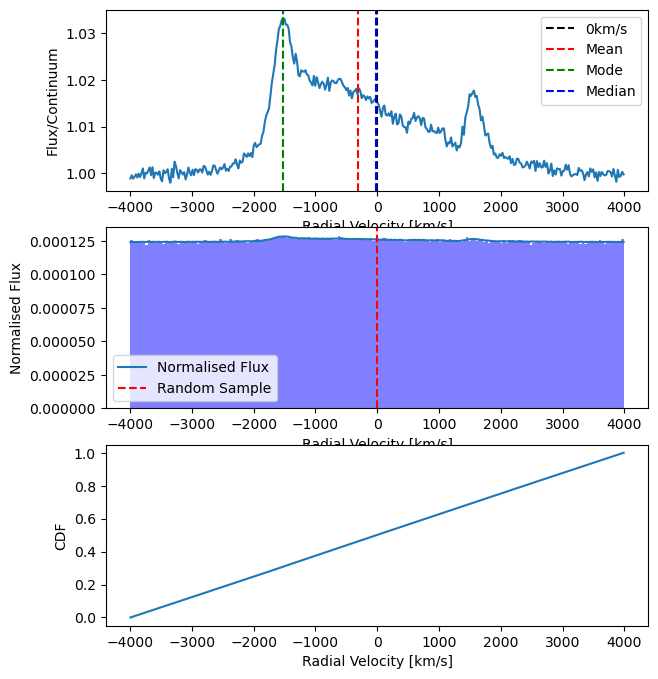

In [9]:
plt.figure(figsize=(7,8))
plt.subplot(3,1,1)
plt.plot(velocity_data, flux_norm)
plt.axvline(0, color='k', linestyle='--', label=r'0km/s')
plt.axvline(mean_raw_moment(flux_norm, velocity_data), color='r', linestyle='--', label='Mean')
plt.axvline(mode, color='g', linestyle='--', label='Mode')
plt.axvline(median, color='b', linestyle='--', label='Median')
plt.legend()
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Flux/Continuum')

plt.subplot(3,1,2)
plt.plot(velocity_data, norm_spectrum)
plt.axvline(0, color='r', linestyle='--', label=r'0km/s')
plt.hist(hist_data, bins=200, density=True, alpha=0.5, color='b')
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Flux')
plt.legend(['Normalised Flux', 'Random Sample'])

plt.subplot(3,1,3)
plt.plot(velocity_data, cdf)
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('CDF')
plt.show()


